In [1]:
import os

import qiskit
import numpy as np
from numpy import pi

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ, transpile
from qiskit.providers.aer import noise
from qiskit.providers.aer import AerSimulator
import qiskit.ignis.mitigation.measurement as mc
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

from dotenv import load_dotenv
load_dotenv()


True

## Credentials/Backend

In [2]:
IBMQ # This makes the next cell work properly and I have no idea why

In [3]:
IBMQ.ibmq.enable_account(os.environ['TOKEN'])

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
dir(IBMQ.ibmq)
IBMQ.ibmq.providers()[0].backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [5]:
provider = IBMQ.ibmq.providers()[0]

backend = provider.get_backend('ibmqx2')

sim = AerSimulator.from_backend(backend)

## Parameters

In [6]:
gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

theta_d = 2*np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2*np.arcsin(np.sqrt(gain_amp * dt))

## Circuit

In [7]:
z_arg = -detuning * dt / 2
y_arg = -signal_strength * dt

qreg_q = QuantumRegister(2, "q")
creg_c = ClassicalRegister(1, "c")

qc = QuantumCircuit(qreg_q, creg_c)

for _ in range(35):
    qc.u(z_arg, y_arg, z_arg, qreg_q[0])

    # Loss
    qc.cu(theta_d, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[1], qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

    # Gain
    qc.u(-pi, 0, 0, qreg_q[0])
    qc.cx(qreg_q[0], qreg_q[1])
    qc.cu(theta_g, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[0], qreg_q[1])
    qc.u(pi, 0, 0, qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

# qc.measure_all()

# qc.draw(fold=150)


## Tomography Setup

In [8]:
qpt_circs = state_tomography_circuits(qc, qreg_q[0])

C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  ci

In [9]:
# qpt_circs[0].draw(fold=150)

## Simulation

### Calibration Circuit

In [10]:
# cal_qr = QuantumRegister(2)
# cal_cr = [ClassicalRegister(1), ClassicalRegister(1)]

# meas_calibs, state_labels = mc.complete_meas_cal(qr=QuantumRegister(1), cr=ClassicalRegister(2))
# job_cal = sim.run(meas_calibs, shots=8192)

# meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)

### Main Circuit with Noise

In [11]:
qpt_circs_compiled = transpile(qpt_circs, sim)
job_tomo = sim.run(qpt_circs_compiled, shots=8192)

result = job_tomo.result()

tomo_state = StateTomographyFitter(result, qpt_circs)

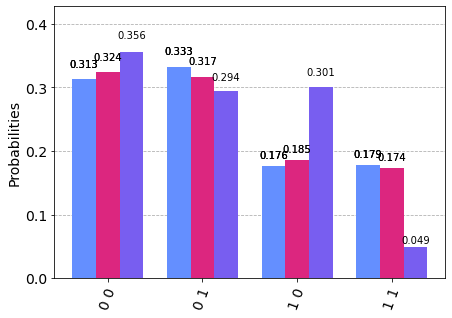

In [12]:
from qiskit.visualization import plot_histogram
counts = job_tomo.result().get_counts()
plot_histogram(counts)


## Tomography

In [13]:
# no correction
state = tomo_state.fit()
# F_state = qi.state_fidelity(state, target_state)
# print("State fidelity (no correction): F = {:.5f}".format(F_state))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.65734863+0.j         -0.0111084 -0.00915527j]
 [-0.0111084 +0.00915527j  0.34265137+0.j        ]]

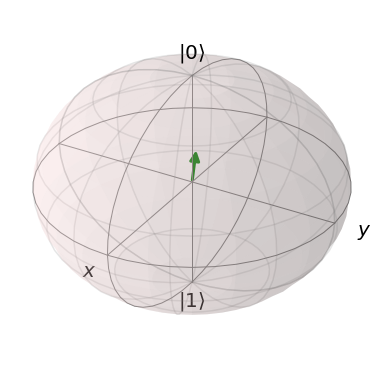

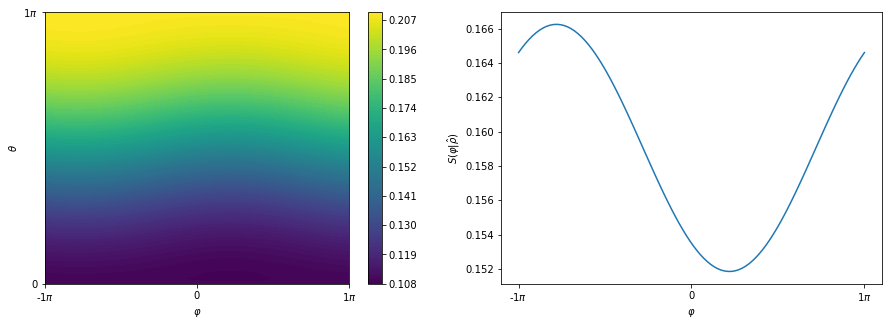

In [14]:
from qutip import Qobj, Bloch
from sync_plots import calc_and_plot_Q_and_S

state = Qobj(state)

b = Bloch()
b.add_states(state)
b.show()

calc_and_plot_Q_and_S(state)

state

In [15]:
# meas_filter = meas_fitter.filter
# mitigated_results = meas_filter.apply(result)

In [16]:
# correct data
# correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method="least_squares")
# tomo_state_mit = StateTomographyFitter(correct_tomo_results, qpt_circs)
# rho_fit_bell_mit = tomo_state_mit.fit(method="lstsq")

# F_bell_mit = qi.state_fidelity(rho_fit_bell_mit, target_state_bell)
# print("State fidelity (w/ correction): F = {:.5f}".format(F_bell_mit))

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table